In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from cycler import cycler
import matplotlib.patches as mpatches
import seaborn as sns
import arviz as az
import scipy.stats as stats
import ROOT as r
import time
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')
%jsroot on

Welcome to JupyROOT 6.26/00


In [2]:
def fit(nsamples,nbins,start): #define starting index
    cols=[f'toybin{i:04d}' for i in range(start,start+nbins)]
    diagnostics_df=pd.DataFrame(columns=cols,index=['sigma_median','mcse','rhat'])
    sigma_df=pd.DataFrame(columns=cols)
    for i in range(start,start+nbins):#no. of toy bins
        print(f"Fitting toy MC bin no.{i}")
        #read data
        df=pd.read_csv(f"toybins/toybin{i:04d}.txt",sep="\t")
        #df=pd.read_csv(f"new_toy_MC.txt",sep="\t")
        df.columns=['pol','phi','weight']
        #these are prompt peak events
        prmpt=df.loc[df['weight']==1]
        prmpt=prmpt.reset_index(drop=True)
        #sideband
        side=df.loc[df['weight']!=1]
        side=side.reset_index(drop=True)
        nprmpt=len(prmpt)
        total_nside=(len(side))
        #weights used in the data, including 1--> exterminate 1
        weights=pd.unique(df['weight'].values)
        weights=np.array(weights[weights!=1])
        #sideband events are identified by the corresponding weights
        nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
        #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
        f=(nprmpt+np.sum(nside*weights))/nprmpt
        print(f)
        stan_data={
            'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
            'phi_prmpt':list(prmpt['phi'].values),
            'pol_prmpt':list(prmpt['pol'].values),
            'M':total_nside,#no. of sideband events and..
            'phi_side':list(side['phi'].values),
            'pol_side':list(side['pol'].values),
            'f':f #fraction of signal in prmpt peak
        }
        print(nprmpt, total_nside)
        #now the stan model and mcmc
        model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
        model.compile()
        fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0,output_dir='./stan_trash',show_progress=False)
        summary=fitobj.summary()
        samples=fitobj.draws_pd()
        #get mcmc diagnostics
        median=summary['50%']['sigma']
        mcse=(az.mcse(np.transpose(fitobj.draws(concat_chains=False)[:,:,7]),method='median'))
        rhat=(summary['R_hat']['sigma'])
        tmp_list=[median,mcse,rhat]
        currbin=f"toybin{i:04d}"
        diagnostics_df[currbin]=tmp_list
        sigma_df[currbin]=samples['sigma']
    return diagnostics_df, sigma_df, summary

def fit_bin(nsamples,binnr): #fit only one bin
    #read data
    df=pd.read_csv(f"toybins/toybin{binnr:04d}.txt",sep="\t")
    df.columns=['pol','phi','weight']
    #these are prompt peak events
    prmpt=df.loc[df['weight']==1]
    prmpt=prmpt.reset_index(drop=True)
    #sideband
    side=df.loc[df['weight']!=1]
    side=side.reset_index(drop=True)
    nprmpt=len(prmpt)
    total_nside=(len(side))
    #weights used in the data, including 1--> exterminate 1
    weights=pd.unique(df['weight'].values)
    weights=np.array(weights[weights!=1])
    #sideband events are identified by the corresponding weights
    nside=np.array([len(df.loc[df['weight']==weights[i]])for i in range(len(weights))])
    #fraction of signal in prompt peak, note that the weights are already negative (TO BE CHECKED W/ FARAHS DATA!)
    f=(nprmpt+np.sum(nside*weights))/nprmpt
    print(f)
    stan_data={
        'N':nprmpt, #no. of prompt peak events and corresponding pol and phi values
        'phi_prmpt':list(prmpt['phi'].values),
        'pol_prmpt':list(prmpt['pol'].values),
        'M':total_nside,#no. of sideband events and..
        'phi_side':list(side['phi'].values),
        'pol_side':list(side['pol'].values),
        'f':f #fraction of signal in prmpt peak
    }
    print(nprmpt, total_nside)
    #now the stan model and mcmc
    model=sp.CmdStanModel(stan_file='toyMC_stan.stan')
    model.compile()
    fitobj=model.sample(data=stan_data,iter_sampling=nsamples,inits=0)
    summary=fitobj.summary()
    samples=fitobj.draws_pd()
    return samples,summary

In [3]:
dfs=fit(nsamples=5000,nbins=1000,start=0)
diagnostics=dfs[0]
sigma=dfs[1]
diagnostics.to_csv('toy_diagnostics.csv')
sigma.to_csv('toy_sigma.csv')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:created output directory: /home/jakob/Documents/Studium/master_thesis/bayes/etap_event_based_fit/stan_trash
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.0
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.1
0.9500413223140496
363 279


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.2
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.3
0.9499180327868852
427 329


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.4
0.9497803617571059
387 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.5
0.94984375
416 321


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.6
0.9500000000000001
403 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.7
0.9498521505376345
372 287


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.8
0.94984375
416 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.9
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.10
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.11
0.9501125
400 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.12
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.13
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.14
0.9497803617571059
387 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.15
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.16
0.9498352941176471
425 328


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.17
0.9500243309002433
411 316


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.18
0.949925925925926
405 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.19
0.949925925925926
405 312


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.20
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.21
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.22
0.9498081534772183
417 322


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.23
0.949934725848564
383 295


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.24
0.9500243309002433
411 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.25
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.26
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.27
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.28
0.9501562499999999
416 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.29
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.30
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.31
0.9499324324324325
370 285


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.32
0.9497803617571059
387 299


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.33
0.9500119047619048
420 323


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.34
0.9500115473441109
433 333


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.35
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.36
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.37
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.38
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.39
0.9500235849056604
424 326


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.40
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.41
0.9498571428571428
420 324


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.42
0.9499762470308789
421 324


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.43
0.9500361445783132
415 319


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.44
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.45
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.46
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.47
0.9498369565217392
460 355


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.48
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.49
0.949925925925926
405 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.50
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.51
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.52
0.9500251256281408
398 306


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.53
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.54
0.9500000000000001
364 280


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.55
0.950099150141643
353 271


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.56
0.9498218527315915
421 325


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.57
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.58
0.9498477157360407
394 304


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.59
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.60
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.61
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.62
0.9498218527315915
421 325


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.63
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.64
0.9499204545454545
440 339


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.65
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.66
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.67
0.9497808219178082
365 282


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.68
0.9500115473441109
433 333


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.69
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.70
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.71
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.72
0.9499616368286445
391 301


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.73
0.9500462962962963
432 332


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.74
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.75
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.76
0.9501089588377724
413 317


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.77
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.78
0.9501162790697675
387 297


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.79
0.9499616368286445
391 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.80
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.81
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.82
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.83
0.9498484848484848
429 331


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.84
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.85
0.9498882681564246
358 276


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.86
0.950012285012285
407 313


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.87
0.949934725848564
383 295


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.88
0.9501666666666667
390 299


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.89
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.90
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.91
0.9498670212765957
376 290


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.92
0.9498831775700934
428 330


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.93
0.9500892857142857
392 301


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.94
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.95
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.96
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.97
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.98
0.95001312335958
381 293


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.99
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.100
0.9499530516431925
426 328


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.101
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.102
0.9498571428571428
420 324


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.103
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.104
0.9499180327868852
427 329


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.105
0.9501044386422977
383 294


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.106
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.107
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.108
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.109
0.9498571428571428
420 324


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.110
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.111
0.9498484848484848
429 331


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.112
0.949909793814433
388 299


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.113
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.114
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.115
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.116
0.9497576530612245
392 303


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.117
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.118
0.9498866213151927
441 340


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.119
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.120
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.121
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.122
0.9500135869565218
368 283


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.123
0.9499762470308789
421 324


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.124
0.9501237623762376
404 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.125
0.950060975609756
410 315


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.126
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.127
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.128
0.949925925925926
405 312


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.129
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.130
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.131
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.132
0.9501369863013699
438 336


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.133
0.9498882681564246
358 276


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.134
0.9498352941176471
425 328


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.135
0.9498484848484848
429 331


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.136
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.137
0.9498670212765957
376 290


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.138
0.9500000000000001
429 330


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.139
0.9498670212765957
376 290


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.140
0.9500724637681159
414 318


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.141
0.950060975609756
410 315


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.142
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.143
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.144
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.145
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.146
0.9499769585253457
434 334


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.147
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.148
0.9497727272727272
374 289


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.149
0.950012285012285
407 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.150
0.9501044386422977
383 294


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.151
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.152
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.153
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.154
0.9498777777777777
450 347


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.155
0.9498741418764303
437 337


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.156
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.157
0.9499407582938388
422 325


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.158
0.94984375
416 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.159
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.160
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.161
0.9499425287356322
435 335


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.162
0.9497967479674797
369 285


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.163
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.164
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.165
0.9497982708933718
347 268


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.166
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.167
0.9499530516431925
426 328


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.168
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.169
0.9500115473441109
433 333


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.170
0.949909793814433
388 299


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.171
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.172
0.9500000000000001
364 280


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.173
0.9497893258426966
356 275


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.174
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.175
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.176
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.177
0.9498047722342734
461 356


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.178
0.9500681818181818
440 338


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.179
0.9499515738498789
413 318


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.180
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.181
0.9497867298578199
422 326


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.182
0.9500115473441109
433 333


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.183
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.184
0.9499180327868852
427 329


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.185
0.949934725848564
383 295


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.186
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.187
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.188
0.9497727272727272
374 289


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.189
0.9498773841961853
367 283


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.190
0.9498997134670487
349 269


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.191
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.192
0.9499425287356322
435 335


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.193
0.9498728813559322
354 273


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.194
0.9498654708520179
446 344


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.195
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.196
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.197
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.198
0.9498019801980199
404 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.199
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.200
0.950012285012285
407 313


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.201
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.202
0.9499445983379502
361 278


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.203
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.204
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.205
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.206
0.9500251256281408
398 306


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.207
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.208
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.209
0.95001269035533
394 303


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.210
0.950012285012285
407 313


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.211
0.9499769585253457
434 334


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.212
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.213
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.214
0.9500977995110024
409 314


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.215
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.216
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.217
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.218
0.9498866213151927
441 340


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.219
0.9498081534772183
417 322


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.220
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.221
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.222
0.9499640287769784
417 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.223
0.949946524064171
374 288


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.224
0.9499303944315546
431 332


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.225
0.9499303944315546
431 332


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.226
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.227
0.9497727272727272
374 289


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.228
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.229
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.230
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.231
0.95
377 290


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.232
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.233
0.9500340136054422
441 339


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.234
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.235
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.236
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.237
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.238
0.9499885844748859
438 337


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.239
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.240
0.9497799511002445
409 316


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.241
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.242
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.243
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.244
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.245
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.246
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.247
0.9499324324324325
370 285


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.248
0.9500243309002433
411 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.249
0.9498004694835681
426 329


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.250
0.9497941888619854
413 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.251
0.949909793814433
388 299


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.252
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.253
0.9500573394495413
436 335


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.254
0.950035046728972
428 329


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.255
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.256
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.257
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.258
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.259
0.9498571428571428
420 324


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.260
0.9498654708520179
446 344


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.261
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.262
0.9497803617571059
387 299


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.263
0.9497727272727273
396 306


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.264
0.9499769585253457
434 334


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.265
0.9498194130925508
443 342


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.266
0.9499865951742628
373 287


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.267
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.268
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.269
0.9499033149171271
362 279


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.270
0.9498218527315915
421 325


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.271
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.272
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.273
0.9501392405063291
395 303


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.274
0.9499204545454545
440 339


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.275
0.9499544419134396
439 338


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.276
0.9499651162790698
430 331


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.277
0.949925925925926
405 312


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.278
0.9500892857142857
392 301


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.279
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.280
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.281
0.9499299719887955
357 275


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.282
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.283
0.9497953964194373
391 302


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.284
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.285
0.9500373134328358
402 309


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.286
0.9499865951742628
373 287


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.287
0.949909793814433
388 299


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.288
0.9499445983379502
361 278


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.289
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.290
0.9499865951742628
373 287


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.291
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.292
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.293
0.94984375
416 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.294
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.295
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.296
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.297
0.95
416 320


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.298
0.9498831775700934
428 330


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.299
0.9498529411764706
442 341


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.300
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.301
0.949909793814433
388 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.302
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.303
0.950012285012285
407 313


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.304
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.305
0.9500000000000001
429 330


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.306
0.9499324324324325
370 285


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.307
0.9497333333333333
375 290


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.308
0.9500508905852417
393 302


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.309
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.310
0.9498521505376345
372 287


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.311
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.312
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.313
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.314
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.315
0.95
377 290


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.316
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.317
0.950025974025974
385 296


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.318
0.950012285012285
407 313


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.319
0.9500119047619048
420 323


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.320
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.321
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.322
0.949934725848564
383 295


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.323
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.324
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.325
0.9498866213151927
441 340


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.326
0.9500373134328358
402 309


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.327
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.328
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.329
0.9499180327868852
427 329


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.330
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.331
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.332
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.333
0.9500000000000001
403 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.334
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.335
0.9498369565217392
368 284


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.336
0.9500977995110024
409 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.337
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.338
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.339
0.9498019801980199
404 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.340
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.341
0.9500235849056604
424 326


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.342
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.343
0.949925925925926
405 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.344
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.345
0.9500373134328358
402 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.346
0.95
377 290


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.347
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.348
0.95
416 320


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.349
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.350
0.9501348039215686
408 313


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.351
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.352
0.9501010101010101
396 304


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.353
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.354
0.9499033149171271
362 279


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.355
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.356
0.9501278772378516
391 300


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.357
0.9498728813559322
354 273


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.358
0.94984375
416 321


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.359
0.9497967479674797
369 285


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.360
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.361
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.362
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.363
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.364
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.365
0.9500398936170212
376 289


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.366
0.9499273255813953
344 265


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.367
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.368
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.369
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.370
0.9498467966573816
359 277


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.371
0.950012285012285
407 313


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.372
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.373
0.9499180327868852
427 329


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.374
0.9498019801980199
404 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.375
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.376
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.377
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.378
0.9497654320987654
405 313


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.379
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.380
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.381
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.382
0.949925925925926
405 312


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.383
0.9499616368286445
391 301


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.384
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.385
0.9497576530612245
392 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.386
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.387
0.9499299719887955
357 275


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.388
0.9500492610837439
406 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.389
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.390
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.391
0.949925925925926
405 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.392
0.9499515738498789
413 318


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.393
0.9498670212765957
376 290


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.394
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.395
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.396
0.9500629722921915
397 305


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.397
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.398
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.399
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.400
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.401
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.402
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.403
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.404
0.9500000000000001
364 280


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.405
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.406
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.407
0.9499530516431925
426 328


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.408
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.409
0.9498728813559322
354 273


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.410
0.94984375
416 321


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.411
0.9498571428571428
420 324


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.412
0.9499407582938388
422 325


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.413
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.414
0.949925925925926
405 312


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.415
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.416
0.9499530516431925
426 328


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.417
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.418
0.9500428571428571
350 269


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.419
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.420
0.9497808219178082
365 282


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.421
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.422
0.9500385604113111
389 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.423
0.9499324324324325
370 285


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.424
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.425
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.426
0.94984375
416 321


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.427
0.949958904109589
365 281


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.428
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.429
0.9497576530612245
392 303


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.430
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.431
0.9498898678414097
454 350


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.432
0.95
390 300


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.433
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.434
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.435
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.436
0.9497727272727272
374 289


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.437
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.438
0.95001269035533
394 303


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.439
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.440
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.441
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.442
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.443
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.444
0.949803664921466
382 295


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.445
0.9497493403693931
379 293


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.446
0.9499407582938388
422 325


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.447
0.9499441964285714
448 345


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.448
0.9500956284153006
366 281


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.449
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.450
0.9499719101123596
356 274


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.451
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.452
0.9497727272727272
352 272


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.453
0.94984375
416 321


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.454
0.9498477157360407
394 304


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.455
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.456
0.9499515738498789
413 318


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.457
0.9499865951742628
373 287


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.458
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.459
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.460
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.461
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.462
0.9501125
400 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.463
0.9499762470308789
421 324


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.464
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.465
0.9497799511002445
409 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.466
0.9500000000000001
429 330


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.467
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.468
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.469
0.949925925925926
405 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.470
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.471
0.9497727272727273
396 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.472
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.473
0.9498622589531681
363 280


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.474
0.9498521505376345
372 287


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.475
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.476
0.9498521505376345
372 287


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.477
0.949925925925926
405 312


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.478
0.949934725848564
383 295


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.479
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.480
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.481
0.9501044386422977
383 294


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.482
0.94984375
416 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.483
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.484
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.485
0.9497967479674797
369 285


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.486
0.9497584541062801
414 320


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.487
0.949803664921466
382 295


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.488
0.95
377 290


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.489
0.9500243309002433
411 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.490
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.491
0.9499865951742628
373 287


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.492
0.949934725848564
383 295


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.493
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.494
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.495
0.9498218527315915
421 325


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.496
0.9498831775700934
428 330


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.497
0.9498218527315915
421 325


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.498
0.9497803617571059
387 299


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.499
0.9498692810457516
459 354


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.500
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.501
0.9501562499999999
416 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.502
0.9498571428571428
420 324


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.503
0.9499661399548532
443 341


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.504
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.505
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.506
0.950120320855615
374 287


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.507
0.9497883597883597
378 292


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.508
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.509
0.9497875
400 309


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.510
0.9498467966573816
359 277


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.511
0.949934725848564
383 295


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.512
0.9497658079625293
427 330


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.513
0.9498214285714286
364 281


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.514
0.9498477157360407
394 304


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.515
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.516
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.517
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.518
0.9499882352941177
425 327


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.519
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.520
0.9499530516431925
426 328


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.521
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.522
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.523
0.949909793814433
388 299


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.524
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.525
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.526
0.9499530516431925
426 328


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.527
0.95
390 300


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.528
0.9500361445783132
415 319


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.529
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.530
0.9497875
400 309


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.531
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.532
0.95001312335958
381 293


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.533
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.534
0.9500724637681158
345 265


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.535
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.536
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.537
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.538
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.539
0.9497799511002445
409 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.540
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.541
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.542
0.9497803617571059
387 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.543
0.9500278551532033
359 276


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.544
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.545
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.546
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.547
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.548
0.9500135869565218
368 283


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.549
0.949925925925926
405 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.550
0.949925925925926
405 312


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.551
0.9499515738498789
413 318


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.552
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.553
0.94984375
416 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.554
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.555
0.95
416 320


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.556
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.557
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.558
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.559
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.560
0.9498214285714286
364 281


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.561
0.9501089588377724
413 317


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.562
0.9499204545454545
440 339


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.563
0.9500492610837439
406 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.564
0.9499530516431925
426 328


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.565
0.9497237569060774
362 280


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.566
0.9498477157360407
394 304


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.567
0.9499407582938388
422 325


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.568
0.9497875
400 309


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.569
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.570
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.571
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.572
0.949925925925926
405 312


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.573
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.574
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.575
0.949958904109589
365 281


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.576
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.577
0.9500508905852417
393 302


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.578
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.579
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.580
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.581
0.9497941888619854
413 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.582
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.583
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.584
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.585
0.949946524064171
374 288


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.586
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.587
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.588
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.589
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.590
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.591
0.9497953964194373
391 302


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.592
0.949934725848564
383 295


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.593
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.594
0.9497727272727272
418 323


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.595
0.9499033149171271
362 279


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.596
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.597
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.598
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.599
0.95
377 290


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.600
0.9497953964194373
391 302


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.601
0.9499651162790698
430 331


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.602
0.9500748129675811
401 308


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.603
0.949934725848564
383 295


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.604
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.605
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.606
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.607
0.9499180327868852
366 282


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.608
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.609
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.610
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.611
0.9497953964194373
391 302


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.612
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.613
0.9498997134670487
349 269


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.614
0.9499865951742628
373 287


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.615
0.9498529411764706
442 341


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.616
0.9499324324324325
370 285


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.617
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.618
0.9498958333333334
432 333


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.619
0.9500837320574163
418 321


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.620
0.9500000000000001
429 330


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.621
0.949934725848564
383 295


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.622
0.94984375
416 321


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.623
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.624
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.625
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.626
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.627
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.628
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.629
0.949925925925926
405 312


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.630
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.631
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.632
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.633
0.950012285012285
407 313


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.634
0.9498773841961853
367 283


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.635
0.9500119047619048
420 323


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.636
0.9498019801980199
404 312


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.637
0.949946524064171
374 288


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.638
0.9498019801980199
404 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.639
0.9498401826484018
438 338


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.640
0.949908256880734
436 336


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.641
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.642
0.9499640287769784
417 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.643
0.9498891625615763
406 313


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.644
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.645
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.646
0.9497875
400 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.647
0.9497576530612245
392 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.648
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.649
0.9500235849056604
424 326


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.650
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.651
0.9497727272727272
374 289


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.652
0.949925925925926
405 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.653
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.654
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.655
0.9498521505376345
372 287


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.656
0.9498004694835681
426 329


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.657
0.9499180327868852
366 282


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.658
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.659
0.9498369565217392
368 284


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.660
0.949803664921466
382 295


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.661
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.662
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.663
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.664
0.9500222222222222
450 346


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.665
0.9500235849056604
424 326


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.666
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.667
0.9497506234413966
401 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.668
0.9499066666666666
375 289


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.669
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.670
0.9498773841961853
367 283


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.671
0.9499616368286445
391 301


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.672
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.673
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.674
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.675
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.676
0.95001312335958
381 293


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.677
0.95
416 320


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.678
0.9498988764044943
445 343


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.679
0.949803664921466
382 295


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.680
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.681
0.95
377 290


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.682
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.683
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.684
0.9497727272727272
374 289


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.685
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.686
0.9500000000000001
403 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.687
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.688
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.689
0.950025974025974
385 296


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.690
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.691
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.692
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.693
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.694
0.949946524064171
374 288


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.695
0.9499109131403117
449 346


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.696
0.9500115473441109
433 333


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.697
0.9499180327868852
427 329


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.698
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.699
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.700
0.9500115473441109
433 333


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.701
0.9500000000000001
403 310


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.702
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.703
0.9498218527315915
421 325


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.704
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.705
0.950035046728972
428 329


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.706
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.707
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.708
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.709
0.9499033149171271
362 279


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.710
0.9500591016548463
423 325


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.711
0.950025974025974
385 296


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.712
0.9499150141643059
353 272


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.713
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.714
0.9499651162790698
430 331


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.715
0.9498795180722891
415 320


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.716
0.9499616368286445
391 301


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.717
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.718
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.719
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.720
0.9498571428571428
385 297


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.721
0.95001312335958
381 293


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.722
0.949925925925926
405 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.723
0.949909793814433
388 299


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.724
0.9497875
400 309


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.725
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.726
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.727
0.9500000000000001
403 310


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.728
0.9499407582938388
422 325


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.729
0.9501044386422977
383 294


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.730
0.9497654320987654
405 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.731
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.732
0.9499066666666666
375 289


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.733
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.734
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.735
0.9499640287769784
417 321


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.736
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.737
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.738
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.739
0.9498401826484018
438 338


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.740
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.741
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.742
0.9497506234413966
401 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.743
0.95
351 270


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.744
0.95001269035533
394 303


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.745
0.94984375
416 321


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.746
0.9498123324396782
373 288


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.747
0.95
377 290


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.748
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.749
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.750
0.950012285012285
407 313


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.751
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.752
0.9497953964194373
391 302


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.753
0.9498218527315915
421 325


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.754
0.949925925925926
405 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.755
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.756
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.757
0.9497650130548303
383 296


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.758
0.950035046728972
428 329


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.759
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.760
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.761
0.95001312335958
381 293


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.762
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.763
0.9499870466321243
386 297


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.764
0.9499407582938388
422 325


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.765
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.766
0.9498622589531681
363 280


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.767
0.9498467966573816
359 277


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.768
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.769
0.9498571428571428
350 270


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.770
0.9501392405063291
395 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.771
0.9497645429362881
361 279


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.772
0.9499889135254989
451 347


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.773
0.9500235849056604
424 326


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.774
0.949908256880734
436 336


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.775
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.776
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.777
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.778
0.94984375
416 321


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.779
0.9499500000000001
400 308


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.780
0.9499407582938388
422 325


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.781
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.782
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.783
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.784
0.9499874686716793
399 307


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.785
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.786
0.9499425287356322
435 335


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.787
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.788
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.789
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.790
0.949934725848564
383 295


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.791
0.9498369565217392
368 284


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.792
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.793
0.9500544959128066
367 282


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.794
0.9499515738498789
413 318


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.795
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.796
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.797
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.798
0.95001269035533
394 303


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.799
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.800
0.949925925925926
405 312


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.801
0.9500629722921915
397 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.802
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.803
0.9499303944315546
431 332


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.804
0.9497941888619854
413 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.805
0.950012285012285
407 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.806
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.807
0.949946524064171
374 288


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.808
0.950132275132275
378 290


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.809
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.810
0.9498958333333334
432 333


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.811
0.9501369863013699
438 336


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.812
0.9498271889400922
434 335


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.813
0.9500492610837439
406 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.814
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.815
0.9499728997289973
369 284


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.816
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.817
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.818
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.819
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.820
0.9498477157360407
394 304


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.821
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.822
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.823
0.9499033149171271
362 279


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.824
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.825
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.826
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.827
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.828
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.829
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.830
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.831
0.9500119047619048
420 323


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.832
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.833
0.9500385604113111
389 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.834
0.9497727272727273
396 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.835
0.9500361445783132
415 319


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.836
0.9497867298578199
422 326


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.837
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.838
0.94974043715847
366 283


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.839
0.9500651041666667
384 295


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.840
0.9498670212765957
376 290


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.841
0.9500251256281408
398 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.842
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.843
0.949925925925926
405 312


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.844
0.9499769585253457
434 334


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.845
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.846
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.847
0.9499127182044889
401 309


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.848
0.9500000000000001
364 280


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.849
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.850
0.9499640287769784
417 321


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.851
0.9499154589371981
414 319


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.852
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.853
0.95
390 300


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.854
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.855
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.856
0.9500361445783132
415 319


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.857
0.9500268817204301
372 286


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.858
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.859
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.860
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.861
0.9499066666666666
375 289


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.862
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.863
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.864
0.9497727272727273
396 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.865
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.866
0.949958904109589
365 281


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.867
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.868
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.869
0.9499878640776699
412 317


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.870
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.871
0.9499603174603174
378 291


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.872
0.9500462962962963
432 332


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.873
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.874
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.875
0.9498521505376345
372 287


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.876
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.877
0.9499150141643059
353 272


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.878
0.9499033149171271
362 279


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.879
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.880
0.9497567567567569
370 286


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.881
0.9498387096774195
403 311


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.882
0.9498773841961853
367 283


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.883
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.884
0.9497953964194373
391 302


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.885
0.9498139534883722
430 332


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.886
0.9500268817204301
372 286


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.887
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.888
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.889
0.950275
400 306


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.890
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.891
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.892
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.893
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.894
0.9498214285714286
364 281


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.895
0.9498425196850393
381 294


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.896
0.9498670212765957
376 290


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.897
0.9498081534772183
417 322


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.898
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.899
0.9499180327868852
427 329


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.900
0.9498661800486617
411 317


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.901
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.902
0.949925925925926
405 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.903
0.9497875
400 309


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.904
0.9499616368286445
391 301


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.905
0.9500629722921915
397 305


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.906
0.9497727272727272
418 323


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.907
0.9497867298578199
422 326


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.908
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.909
0.9498618090452262
398 307


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.910
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.911
0.949925925925926
405 312


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.912
0.9499208443271767
379 292


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.913
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.914
0.9498525798525798
407 314


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.915
0.9498670212765957
376 290


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.916
0.9499388753056234
409 315


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.917
0.9499640287769784
417 321


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.918
0.9498484848484848
429 331


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.919
0.949909793814433
388 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.920
0.9499746835443038
395 304


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.921
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.922
0.9500629722921915
397 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.923
0.9497650130548303
383 296


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.924
0.9497803617571059
387 299


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.925
0.9497654320987654
405 313


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.926
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.927
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.928
0.9499616368286445
391 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.929
0.9499628712871288
404 311


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.930
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.931
0.950132275132275
378 290


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.932
0.9499515738498789
413 318


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.933
0.9500228832951946
437 336


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.934
0.9497567567567569
370 286


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.935
0.949934725848564
383 295


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.936
0.9498958333333334
432 333


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.937
0.9499865951742628
373 287


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.938
0.9498702830188679
424 327


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.939
0.95
377 290


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.940
0.9499483204134367
387 298


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.941
0.9498186528497409
386 298


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.942
0.9501392405063291
395 303


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.943
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.944
0.9497727272727272
374 289


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.945
0.949925925925926
405 312


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.946
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.947
0.9499754901960784
408 314


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.948
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.949
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.950
0.9499033149171271
362 279


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.951
0.9498714652956298
389 300


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.952
0.9498275862068964
377 291


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.953
0.9499054373522459
423 326


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.954
0.9498352941176471
425 328


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.955
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.956
0.94984375
416 321


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.957
0.9498815789473684
380 293


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.958
0.9499769585253457
434 334


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.959
0.9499762470308789
421 324


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.960
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.961
0.9498840579710144
345 266


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.962
0.9500000000000001
403 310


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.963
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.964
0.94974043715847
366 283


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.965
0.9498571428571428
420 324


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.966
0.9500119047619048
420 323


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.967
0.9498958333333333
384 296


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.968
0.9498921832884097
371 286


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.969
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.970
0.9498161764705881
408 315


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.971
0.9499234693877551
392 302


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.972
0.9499368686868687
396 305


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.973
0.9499024390243902
410 316


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.974
0.9499762470308789
421 324


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.975
0.9500724637681159
414 318


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.976
0.9499150141643059
353 272


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.977
0.9500508905852417
393 302


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.978
0.9498245614035088
399 308


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.979
0.9499640287769784
417 321


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.980
0.9498101265822785
395 305


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.981
0.949925925925926
405 312


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.982
0.9498756218905473
402 310


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.983
0.9498926014319808
419 323


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.984
0.95001269035533
394 303


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.985
0.9497237569060774
362 280


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.986
0.9498958333333334
336 259


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.987
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.988
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.989
0.95001269035533
394 303


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.990
0.9498854961832062
393 303


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.991
0.9497883597883597
378 292


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.992
0.9497493403693931
379 293


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.993
0.9499282296650717
418 322


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.994
0.9498300970873786
412 318


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.995
0.9498333333333333
390 301


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.996
0.9498992443324937
397 306


INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.997
0.9499738219895287
382 294


INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.998
0.9499303944315546
431 332


INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start procesing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


Fitting toy MC bin no.999
0.9499066666666666
375 289


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing


In [5]:
sigma_df=pd.read_csv('toy_sigma.csv',index_col=0)
diagnostics_df=pd.read_csv('toy_diagnostics.csv',index_col=0)

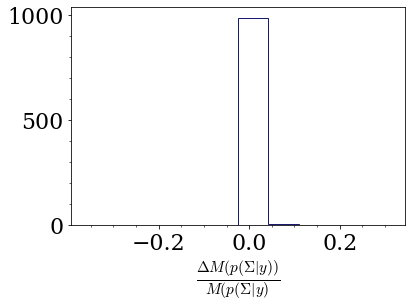

In [6]:
rel_err=[(diagnostics_df[f'toybin{i:04d}']['mcse']/diagnostics_df[f'toybin{i:04d}']['sigma_median']) for i in range(len(diagnostics_df.columns))]
plt.hist(rel_err,histtype='step',color='midnightblue')
plt.xlabel('$\\frac{\Delta M(p(\Sigma|y))}{M(p(\Sigma|y)}$')
plt.grid(False)
#plt.savefig('./plots/toyMC_mcse_hist.pdf',format='pdf',dpi=1000,bbox_inches='tight')
plt.show()

In [7]:
all_sigmas=[]
for i in range(len(sigma_df.columns)):
    all_sigmas.extend((np.array(sigma_df[f'toybin{i:04d}'].values)))

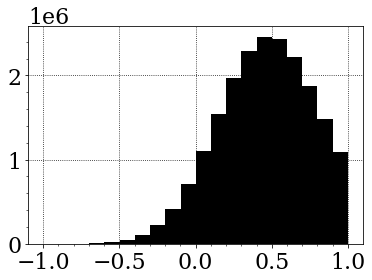

In [8]:
plt.hist(all_sigmas,bins=20)
plt.show()